In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=2)

In [3]:
'''
getting some data
'''
from eden.converter.graph.gspan import gspan_to_eden
def getgraphs():
    return  gspan_to_eden( 'bursi.pos.gspan' )


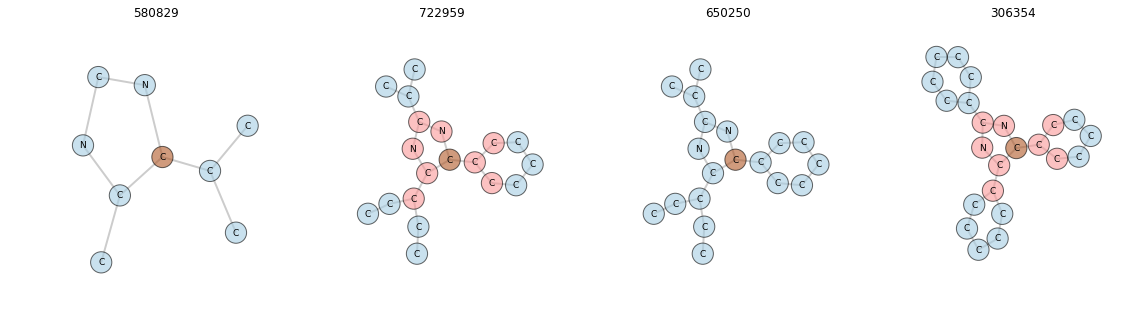

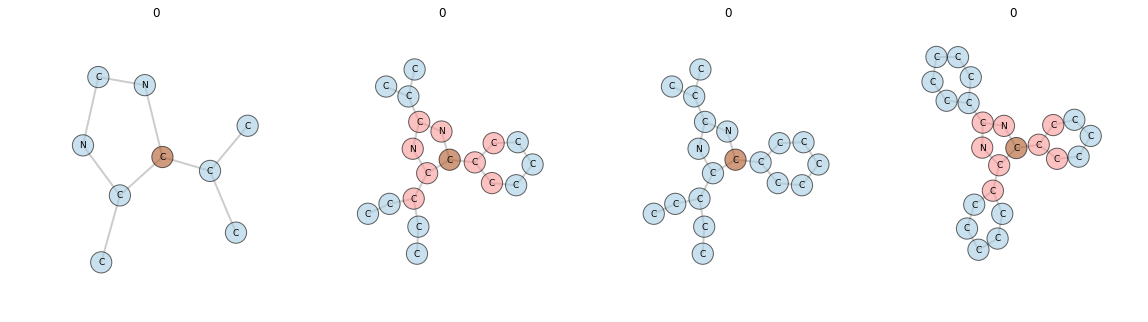

In [5]:
'''
INITIAL TEST OF THINGS 
'''

%matplotlib inline
from eden.converter.graph.gspan import gspan_to_eden
from graphlearn import graphtools as gt
import graphlearn.utils.draw as myutils
import eden.graph as eg
import graphlearn.graphlearn as gl
import numpy as np

from eden.graph import Vectorizer
vectorizer=Vectorizer()

#get a graph
graphs = gspan_to_eden( 'bursi.pos.gspan' )
graph=graphs.next()
from eden.util import display
from eden.modifier.graph.vertex_attributes import colorize  
graphs = colorize([graph],output_attribute = 'color_level', labels = ['C','O','N','P','Cl','Br','S'])    
graph=graphs.next()
'''
print 'We work on this graph'
display.draw_graph(graph, size=10, secondary_vertex_label='ID',
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                   vertex_alpha=0.5, node_size=650)
'''

def mark_and_draw(cips):
    graphs=myutils.cip_to_graph(cips)
    
    for cip,g in zip(cips,graphs):
        g.graph['info']=cip.interface_hash
    
    zomg = lambda x:x.graph['info']
    
    myutils.draw_graph_set_graphlearn(graphs, 
                           n_graphs_per_line=7, size=5, 
                           colormap='Paired', invert_colormap=False,node_border=1,
                           vertex_alpha=0.6, edge_alpha=0.2, node_size=450,headlinehook=zomg)
radius_list=[0,2]
thickness_list=[2,4]
cips=gl.extract_core_and_interface(1,graph,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
mark_and_draw(cips)
import graphlearn.graphtools as graphtools
test = lambda x,y: 0
graphtools.calc_interface_hash = test
cips=gl.extract_core_and_interface(1,graph,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
mark_and_draw(cips)

In [7]:
%%time
'''
OKOKOKOKOK what i tried above doesnt work .. so i need to change the grammar 
'''
import os 
os.nice(20)
%matplotlib inline
import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
import itertools
from graphlearn.localsubstitutablegraphgrammar import LocalSubstitutableGraphGrammar
from graphlearn import graphtools
from graphlearn import localsubstitutablegraphgrammar
import traceback
import networkx as nx


def _get_args2(self):
    return  [self.radius_list, self.thickness_list, self.vectorizer, self.hash_bitmask, self.node_entity_check,self.esti]

def extract_cores_and_interfaces2(parameters):
    # happens if batcher fills things up with null
    if parameters[0] is None:
        return None
    try:
        # unpack arguments, expand the graph
        graph, radius_list, thickness_list, vectorizer, hash_bitmask, node_entity_check ,esti = parameters
        graph = vectorizer._edge_to_vertex_transform(graph)
        cips = []
        for node in graph.nodes_iter():
            if 'edge' in graph.node[node]:
                continue
            cip_list = graphtools.extract_core_and_interface2(node, graph, radius_list, thickness_list,
                                                                        vectorizer=vectorizer,
                                                                        hash_bitmask=hash_bitmask,
                                                                        filter=node_entity_check,esti=esti)
            if cip_list:
                cips.append(cip_list)
        return cips
    except Exception as exc:
        print 'DONG'
        print traceback.format_exc(10)

    
    
# OVERWRITING FOR TEST PURPOSES
LocalSubstitutableGraphGrammar._get_args=_get_args2    
localsubstitutablegraphgrammar.extract_cores_and_interfaces=extract_cores_and_interfaces2

# learn a grammar
training_graphs = gspan_to_eden( 'bursi.pos.gspan' )
training_size=200
training_graphs = itertools.islice(training_graphs,training_size)
sampler=gl.GraphLearnSampler(radius_list=[0,1,2],thickness_list=[1.5,2],core_interface_pair_remove_threshold=1, interface_remove_threshold=1)
                                    
'''
def fit(self, graphs,
            core_interface_pair_remove_threshold=2,
            interface_remove_threshold=2,
            n_jobs=-1,
            nu=.5,batch_size=10):
        """
          use input to fit the grammar and fit the estimator
        """
        graphs, graphs_ = itertools.tee(graphs)

        self.estimator = self.estimatorobject.fit(graphs_, vectorizer=self.vectorizer, nu=nu, n_jobs=n_jobs)

        self.local_substitutable_graph_grammar.fit(graphs, n_jobs,batch_size=batch_size)
'''
                                              
n_jobs=1
graphs, graphs_ = itertools.tee(training_graphs)
sampler.estimator = sampler.estimatorobject.fit(graphs_, vectorizer=sampler.vectorizer, nu=0.5, n_jobs=n_jobs)
sampler.local_substitutable_graph_grammar.esti= sampler.estimator

graphs=itertools.islice(graphs,10)
sampler.local_substitutable_graph_grammar.fit(graphs, n_jobs,batch_size=10)
sampler.save('tmp/demo_200.ge')



Classifier:
SGDClassifier(alpha=0.000314148141837, average=False, class_weight=None,
       epsilon=0.1, eta0=0.467699667709, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='log', n_iter=94, n_jobs=1,
       penalty='l1', power_t=0.391260351488, random_state=None,
       shuffle=True, verbose=0, warm_start=False)

Predictive performance:
            accuracy: 1.000 +- 0.000
           precision: 1.000 +- 0.000
              recall: 1.000 +- 0.000
                  f1: 1.000 +- 0.000
   average_precision: 1.000 +- 0.000
             roc_auc: 1.000 +- 0.000
Saved model: tmp/demo_200.ge
CPU times: user 38.8 s, sys: 3.86 s, total: 42.6 s
Wall time: 38.1 s


interface: 0.9676044


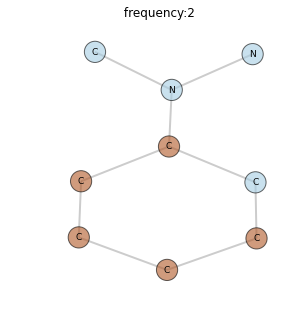

interface: 0.4530046


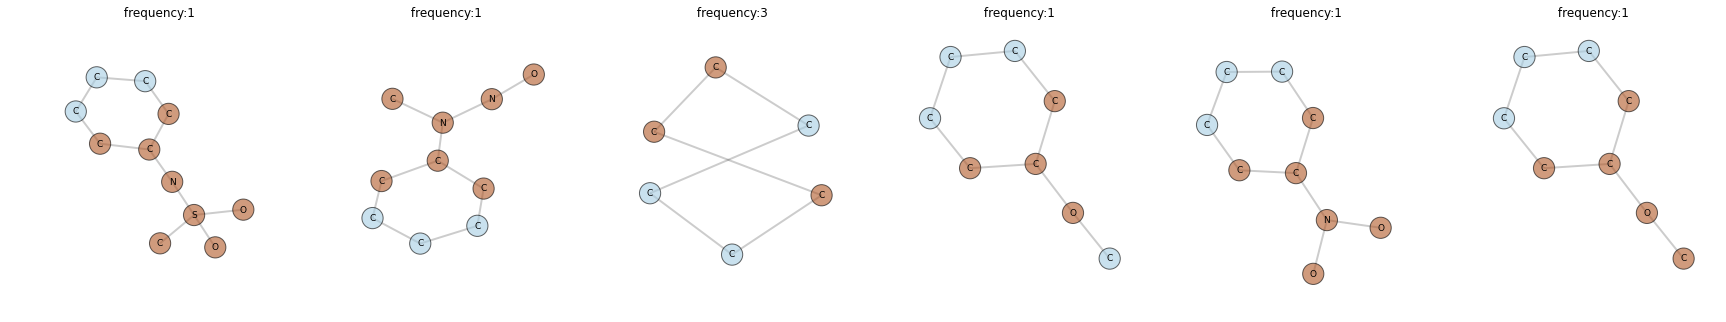

interface: 0.7918613


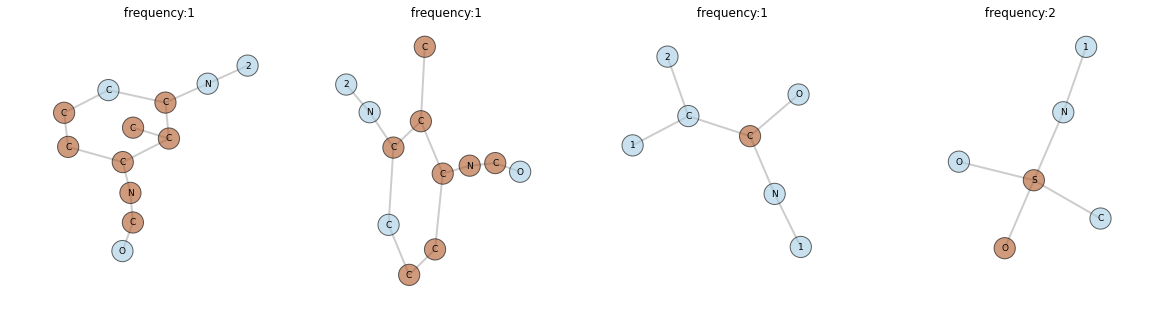

interface: 0.9375887


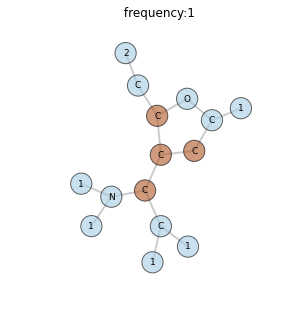

interface: 0.9724603


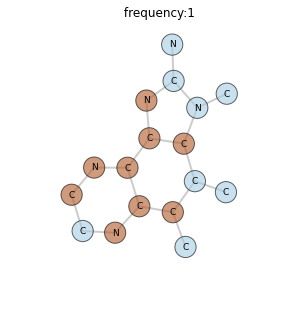

In [8]:
#draw production rules
myutils.draw_grammar(sampler.local_substitutable_graph_grammar.grammar,n_productions=5,
                     n_graphs_per_line=6, size=5, 
                     colormap='Paired', invert_colormap=False,node_border=1,
                     vertex_alpha=0.6, edge_alpha=0.2, node_size=450)
